In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('../data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import math
import random
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import AutoModel, AutoTokenizer
from captum.attr import LayerIntegratedGradients

from language_training_utils import *

# import language_training_utils
# importlib.reload(language_training_utils)
# from language_training_utils import *

# Language Clustering

Clustering experiments with text feature extractors. The idea is to fine-tune some pre-trained transformer models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## BERTimbau

'descricao' token-length statistics:
Min: 2; Max: 420; 
Mean: 56.91137187559626; std: 35.49477155731764; 
Mode: ModeResult(mode=33, count=380); 
Q1: 32.0; 
Q2: 49.0; 
Q3: 73.0;
How many sentences longer than 128 tokens? 856



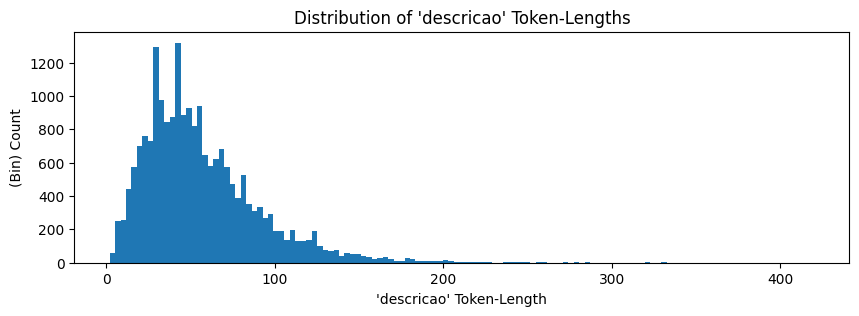

In [4]:
# Studying the distribution of sentence token-lengths on dataframe 'descricao' to make a 
# decision regarding the max sequence length to use for models (also with memory restrictions)
sentence_list = list(ind_df['descricao'].dropna())
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', \
                                          do_lower_case=False)
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in sentence_list]
token_lengths = np.array(token_lengths)

# Printing statistics and finding out that, given the small amount of sentences with more than
# 128 tokens, maybe we don't need to run an entire LLM pipeline to reduce sentence lengths. 
# Having said that, sequence length of 64 is pretty tight and would make us lose around 30%
# of our data with no LLM pipeline to reduce sentences
print("'descricao' token-length statistics:")
print(f"""Min: {np.min(token_lengths)}; Max: {np.max(token_lengths)}; 
Mean: {np.mean(token_lengths)}; std: {np.std(token_lengths)}; 
Mode: {stats.mode(token_lengths)}; 
Q1: {np.quantile(token_lengths, 0.25)}; 
Q2: {np.quantile(token_lengths, 0.50)}; 
Q3: {np.quantile(token_lengths, 0.75)};""")
print(f"How many sentences longer than 128 tokens? {len(np.where(token_lengths > 128)[0])}\n")

# Plotting distribution
plt.figure(figsize=(10, 3))
plt.hist(token_lengths, \
         bins=int(len(np.unique(token_lengths))/2))
plt.xlabel("'descricao' Token-Length")
plt.ylabel("(Bin) Count")
plt.title("Distribution of 'descricao' Token-Lengths")
plt.show()

Due to the very small amount of sentences with more than 128 tokens, and to the fact that, even those, are normally very close to 128 tokens, we decided to postpone the bulding of an LLM pipeline to summarize longer sentences.

### Vanilla Model

In [5]:
# Getting device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# Initializing model, turning it into eval mode and zeroing out the gradients
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = model.to(device)
model.eval()
model.zero_grad()

# Getting sentences' dataset, dataloader and splits
text_ind_df = ind_df[~ind_df['descricao'].isna()]
max_length = 128
text_dataset = TextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)

data_size = len(text_dataset)
train_size = int(0.8*data_size)
val_size = int(0.1*data_size)
test_size = data_size - train_size - val_size
splits = [train_size, val_size, test_size]
split_batch_size = 32
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)

# Initializing baseline input_ids and attention_mask, and computing its embedding
baseline_input_ids = torch.full((1, max_length), tokenizer.pad_token_id).to(device)
baseline_input_ids[:, 0] = tokenizer.cls_token_id
baseline_input_ids[:, -1] = tokenizer.sep_token_id
baseline_attention_mask = torch.zeros_like(baseline_input_ids).to(device)
baseline_attention_mask[:, 0] = 1
baseline_attention_mask[:, -1] = 1
with torch.no_grad():
    baseline_outputs = model(input_ids=baseline_input_ids, \
                             attention_mask=baseline_attention_mask)
    baseline_embedding = baseline_outputs.last_hidden_state[:, 0]

# Initializing captum compatible model and layer integrated gradients. We use layer integrated
# gradients here because we can't compute gradients with respect to (discrete) indices
# directly, so we compute gradients with respect to the embeddings of the input tokens
vanilla_wrapped_model = CaptumWrappedModel(model, tokenizer.pad_token_id, \
                                          baseline_embedding, device, target_type='cos-sim')
vanilla_wrapped_model.eval()

lig = LayerIntegratedGradients(vanilla_wrapped_model, model.embeddings)

In [6]:
# Iterating through the dataloader to compute embeddings and token attributions
analyzed_sample = 0
vanilla_bertimbau_indices = []
vanilla_bertimbau_embeddings = []
vanilla_bertimbau_tokens = []
vanilla_bertimbau_attributions = []
for indices, input_ids, _ in tqdm(text_dataloader):
    # Saving indices
    vanilla_bertimbau_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing [CLS] token embeddings
    cls_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=False)
    vanilla_bertimbau_embeddings.append(cls_embeddings.cpu().detach())

    # Computing attributions
    tokens, attributions, delta = get_attributions(lig, tokenizer, input_ids, \
                                                   baseline_input_ids, \
                                                   attrib_aggreg_type='l2-norm', \
                                                   return_tokens=True, \
                                                   verbose=False, \
                                                   sample_num=min(analyzed_sample, \
                                                                  full_batch_size-1))
    vanilla_bertimbau_tokens.append(tokens)
    vanilla_bertimbau_attributions.append(attributions)

    # break
    
# Concatenating the batches
vanilla_bertimbau_indices = np.array(vanilla_bertimbau_indices)
vanilla_bertimbau_embeddings = torch.cat(vanilla_bertimbau_embeddings, dim=0)
vanilla_bertimbau_tokens = np.array(vanilla_bertimbau_tokens)
vanilla_bertimbau_attributions = np.array(torch.cat(vanilla_bertimbau_attributions, dim=0))

100%|█████████████████| 20964/20964 [2:16:00<00:00,  2.57it/s]


In [8]:
# Getting data projections
vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, \
vanilla_bertimbau_umap = data_projections(np.array(vanilla_bertimbau_embeddings))

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_bertimbau_trimap = normalize(vanilla_bertimbau_trimap, norm_factor)
vanilla_bertimbau_tsne = normalize(vanilla_bertimbau_tsne, norm_factor)
vanilla_bertimbau_umap = normalize(vanilla_bertimbau_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. Thi

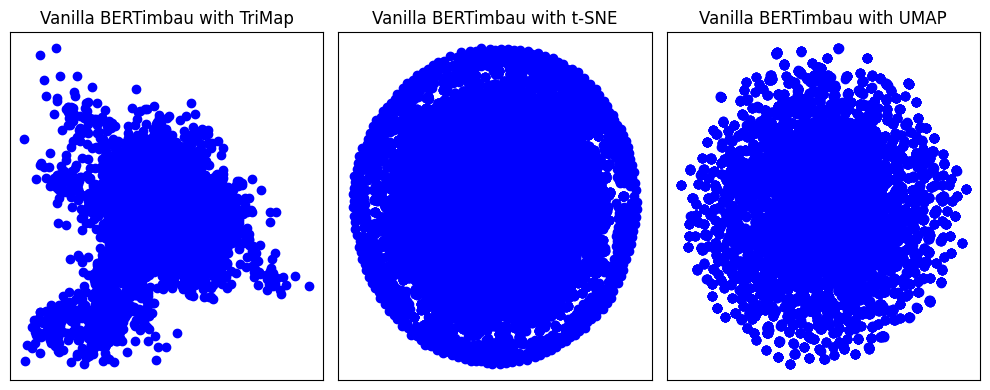

In [9]:
# Utility function to plot rows on projection comparison plot
def row_scatter_plot(projs, proj_names, row, color, rows=1, cols=3):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(10,4))
# plt.suptitle('Comparing Projections of BERTimbau Models')

# Plotting vanilla BERTimbau projections
projs = [vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, vanilla_bertimbau_umap]
proj_names = ['Vanilla BERTimbau with TriMap', 'Vanilla BERTimbau with t-SNE', \
              'Vanilla BERTimbau with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [17]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(vanilla_bertimbau_trimap, vanilla_bertimbau_tokens, \
                   vanilla_bertimbau_attributions, vanilla_bertimbau_indices, \
                   save_file='vanilla_bertimbau_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(vanilla_bertimbau_umap, vanilla_bertimbau_tokens, \
                   vanilla_bertimbau_attributions, vanilla_bertimbau_indices, \
                   save_file='vanilla_bertimbau_umap.csv')

In [ ]:
# Cleaning memory
clean_mem([vanilla_bertimbau_embeddings, vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, \
vanilla_bertimbau_umap, vanilla_bertimbau_attributions, vanilla_bertimbau_indices])

### Unsupervised SimCSE (Contrastive Learning with no Labels)

In [ ]:
# Initializing SimCSE model and auxiliar variables
dropout_prob = 0.1
model = SimCSEModel(model, tokenizer.pad_token_id, device, dropout_prob)
lr = 2e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
epochs = 15
temperature = 0.05
patience = max(4, math.ceil(epochs*0.1))
model_name = 'simcse_bertimbau'
train_dataloader, val_dataloader, test_dataloader = text_dataloader_splits

# Calling training process
simcse_indices, simcse_embeddings, \
train_losses, val_losses = contrastive_training_loop(model, optimizer, train_dataloader, \
                                                     val_dataloader, device, epochs, \
                                                     temperature, patience, model_name)

plot_training_curves(train_losses, val_losses)

In [ ]:
# Recomputing baseline embedding for fine-tuned model
with torch.no_grad():
    baseline_embedding = model(input_ids=baseline_input_ids, train=False)

# Intanciating attribution computation class for fine-tuned model
simcse_wrapped_model = CaptumWrappedModel(model, tokenizer.pad_token_id, \
                                          baseline_embedding, device, target_type='cos-sim')
simcse_wrapped_model.eval()
lig = LayerIntegratedGradients(simcse_wrapped_model, model.embeddings)

# Iterating through the dataloader to compute token attributions for fine-tuned model
analyzed_sample = 0
simcse_bertimbau_indices = []
simcse_bertimbau_embeddings = []
simcse_bertimbau_attributions = []
for indices, input_ids, _ in tqdm(text_dataloader):
    # Saving indices
    simcse_bertimbau_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing [CLS] token embeddings
    cls_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=True)
    simcse_bertimbau_embeddings.append(cls_embeddings.cpu().detach())

    # Computing attributions
    attributions, delta = get_attributions(lig, tokenizer, input_ids, baseline_input_ids, \
                                           attrib_aggreg_type='l2-norm', \
                                           return_tokens=False, verbose=False, \
                                           sample_num=min(analyzed_sample, full_batch_size-1))
    simcse_bertimbau_attributions.append(attributions)

# Concatenating the batches
simcse_bertimbau_indices = torch.cat(simcse_bertimbau_indices, dim=0)
simcse_bertimbau_embeddings = torch.cat(simcse_bertimbau_embeddings, dim=0)
simcse_bertimbau_attributions = torch.cat(simcse_bertimbau_attributions, dim=0)

In [ ]:
# Getting data projections
simcse_bertimbau_trimap, simcse_bertimbau_tsne, \
simcse_bertimbau_umap = data_projections(simcse_bertimbau_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
simcse_bertimbau_trimap = normalize(simcse_bertimbau_trimap, norm_factor)
simcse_bertimbau_tsne = normalize(simcse_bertimbau_tsne, norm_factor)
simcse_bertimbau_umap = normalize(simcse_bertimbau_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(10,6))
# plt.suptitle('Comparing Projections of BERTimbau Models')

# Plotting SimCSE BERTimbau projections
projs = [simcse_bertimbau_trimap, simcse_bertimbau_tsne, simcse_bertimbau_umap]
proj_names = ['SimCSE BERTimbau with TriMap', 'SimCSE BERTimbau with t-SNE', \
              'SimCSE BERTimbau with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [ ]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(simcse_bertimbau_trimap, vanilla_brtimbau_tokens, \
                   simcse_bertimbau_attributions, simcse_bertimbau_indices, \
                   save_file='simcse_bertimbau_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(simcse_bertimbau_umap, vanilla_brtimbau_tokens, \
                   simcse_bertimbau_attributions, simcse_bertimbau_indices, \
                   save_file='simcse_bertimbau_umap.csv')